In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import scipy.interpolate as interp
import lalsimulation as lal
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
from keras import metrics
import keras_metrics as km
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt
import pathlib 
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#gpu configuration:

gpu_num = 0

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

/home/smith26/lscsoft/lalsuite/lib/python3.12/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
2024-06-27 10:11:55.423987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43489 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


2024-06-27 10:11:55.425772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45445 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [9]:
import os
file_path = os.path.join('/home/smith26/public_html/el-nseos-mll', 'preprocessing.csv') #imports file from directory
df = pd.read_csv(file_path, index_col = 0) #makes sure columns stay as they are
df

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      1.704363  0.940013  1.686090  3.498810  2.749811  35.365482  4.163723   
1      0.674195  0.488352  4.630310  5.249203  3.595422  34.654207  3.981949   
2      1.944506  1.625537  2.224806  2.701013  3.520350  35.396764  4.952541   
3      0.582582  0.362044  4.685642  5.651456  2.917128  35.255684  1.149857   
4      2.684166  2.462512  1.709042  1.964290  4.252634  34.932686  3.321473   
...         ...       ...       ...       ...       ...        ...       ...   
49995  1.093111  0.866491  1.965994  2.528221  3.791754  33.440527  4.773079   
49996  0.450100  0.421913  3.340404  4.616534  2.362006  33.940821  2.777913   
49997  1.229125  0.916376  2.503452  3.099723  3.293796  33.026767  4.130634   
49998  0.884386  0.667397  2.974374  5.247997  4.598794  35.306336  3.806648   
49999  2.689961  0.624463  3.588572  4.208695  4.750452  34.792232  4.234088   

       logp2_cgs    gamma2  
0      35.765971  1.138051  
1      34.993765  1.593887  
2      36.017062  1.272790  
3      36.029744  1.967677  
4      35.708051  1.456522  
...          ...       ...  
49995  36.900283  1.091320  
49996  34.595926  1.535013  
49997  34.994576  2.092221  
49998  35.632485  1.049226  
49999  35.206430  1.144645  

[50000 rows x 9 columns]

In [10]:
normeddata = df.copy(deep = True )

In [11]:
def normalizeandwhiten(x):
    gamma0_norm = (x['gamma0'] - 1) / (5 - 1)
    gamma1_norm = (x['gamma1'] - 1) / (5 - 1)
    gamma2_norm = (x['gamma2'] - 1) / (5 - 1)
    #normalizating p values
    logp1_cgs_norm = (x['logp1_cgs'] - 33) / (37 - 33)
    logp2_cgs_norm = (x['logp2_cgs'] - 33) / (37 - 33)
    return gamma0_norm, logp1_cgs_norm, gamma1_norm, logp2_cgs_norm, gamma2_norm
#print(gamma0_norm)
# Call the function and save the normalized values to 'normeddata'
normeddata['gamma0'], normeddata['logp1_cgs'], normeddata['gamma1'], normeddata['logp2_cgs'], normeddata['gamma2'] = normalizeandwhiten(normeddata)

In [12]:
train_dataset = normeddata.sample(frac=0.8, random_state=1)
test_dataset = normeddata.drop(train_dataset.index)

In [13]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [14]:
train_copy = train_dataset.copy()
test_copy = test_dataset.copy()

In [31]:
train_label.shape

(40000, 5)

In [30]:
train_label = train_copy.drop(columns = ['m1', 'm2', 'l1', 'l2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 large training
test_label = test_copy.drop(columns = ['m1', 'm2', 'l1', 'l2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 small testing

train_features = train_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1, m2, l1,l2 large
test_features = test_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1,m2,l1,l2 small


In [32]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import BatchNormalization, Normalization
from keras import regularizers

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperParameters, BayesianOptimization
from keras.regularizers import l2
import keras_tuner
import keras


In [33]:
#custom objective function
#def rmse(y_true, y_pred):
    #return np.sqrt(((y_true - y_targ) ** 2).mean())

train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1],1))

import tensorflow as tf
from tensorflow.keras.layers import Dense

class Norm(tf.keras.Model):
    def __init__(self, norm_layer, *args, **kwargs):
        super(Norm, self).__init__()
        self.norm1 = norm_layer(*args, **kwargs)
        self.fc1 = Dense(units=512, activation=tf.nn.relu)
        self.fc2 = Dense(units=256, activation=tf.nn.relu)
        self.fc3 = Dense(units=256, activation=tf.nn.relu)
        self.fc4 = Dense(units=512, activation=tf.nn.relu)
        self.fc5 = Dense(units=1, activation=tf.nn.sigmoid)

    def call(self, input_tensor):
        fc1 = self.fc1(input_tensor)
        fc1 = self.norm1(fc1)
        fc2 = self.fc2(fc1)
        fc3 = self.fc3(fc2)
        fc4 = self.fc4(fc3)
        fc5 = self.fc5(fc4)
        return fc5
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                 patience=80,
                                 min_delta=0.001, 
                                 mode='auto') 

In [59]:
normalization_layer = Normalization()
normalization_layer.adapt(np.array(train_features))


from sklearn.model_selection import KFold
inputs = np.concatenate((train_features, train_label), axis=0)
targets = np.concatenate((test_features, test_label), axis=0)
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential([
    normalization_layer, 
    keras.layers.Dense(512, activation = 'softmax', kernel_regularizer = regularizers.L2(1e-4)), 
    keras.layers.Dense(256, activation = 'softmax', kernel_regularizer = regularizers.L2(1e-4)),
    keras.layers.Dense(256, activation = 'softmax', kernel_regularizer = regularizers.L2(1e-4)),
    keras.layers.Dense(512, activation = 'softmax', kernel_regularizer = regularizers.L2(1e-4)),
    keras.layers.Dense(5)
    ])
    model.compile(loss = 'cosine_similarity', optimizer = 'adam', metrics = 'accuracy')
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(train_features, train_label,
          batch_size=32,
          epochs=100,
          verbose=1)
    
    # Generate generalization metrics
    scores = model.evaluate(test_features, test_label, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1

In [75]:
model = Sequential([
    normalization_layer, 
    keras.layers.Dense(32, activation = 'relu', kernel_regularizer = regularizers.L2(1e-4)), 
    keras.layers.Dense(64, activation = 'relu', kernel_regularizer = regularizers.L2(1e-4)),
    keras.layers.Dense(256, activation = 'relu', kernel_regularizer = regularizers.L2(1e-4)),
    keras.layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.L2(1e-4)),
    keras.layers.Dense(5)
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 10e-3, clipnorm = 1),
              loss = 'cosine_similarity', metrics = ['accuracy'])

history = model.fit(train_features, train_label, epochs = 200, verbose =1, batch_size = 64, callbacks = callback)

Epoch 1/200


I0000 00:00:1719514078.012661 2641470 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_871', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1719514078.552653 2641467 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_811', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1719514078.977596 2641469 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_841', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1719514079.204655 2641462 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_811', 428 bytes spill stores, 428 bytes spill loads

I0000 00:00:1719514079.697508 2641475 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_871', 428 bytes spill stores, 428 bytes spill loads

I0000 00:00:1719514080.21

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.4438 - loss: -0.8748
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4470 - loss: -0.9381
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.4438 - loss: -0.9387
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.4449 - loss: -0.9385
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4489 - loss: -0.9388
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4477 - loss: -0.9391
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4465 - loss: -0.9389
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4472 - loss: -0.9389
Epoch 9/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4478 - loss: -0.9387 
Epoch 10/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.4459 - loss: -0.9393
Epoch 11/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4491 - loss: -0.9390
Epoch 12/200
625/625 ━━━━━━━━━━━━━

In [76]:
test_predictions = model.predict(train_features)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step


In [77]:
print(test_predictions)

[[19.284 10.358 16.424 20.268  4.238]
 [17.823 10.352 16.966 21.378  5.474]
 [18.56  10.353 16.688 20.811  4.846]
 ...
 [19.284 10.358 16.424 20.268  4.238]
 [19.284 10.358 16.424 20.268  4.238]
 [19.029 10.353 16.509 20.447  4.445]]


In [78]:
lab_max = normeddata['gamma0'].max()
lab_min = normeddata['gamma0'].min()
lab_range = lab_max - lab_min
lab_mean = normeddata['gamma0'].mean()
print(lab_max, lab_min, lab_range, lab_mean)

0.99999834196278 7.982410285611863e-05 0.9999185178599239 0.6411786126206468


In [79]:
pred_max = test_predictions[:, [0]].max()
pred_min = test_predictions[:, [0]].min()
pred_range = pred_max - pred_min
pred_mean = test_predictions[:, [0]].mean()
print(pred_max, pred_min, pred_range, pred_mean)

19.283707 17.18425 2.0994568 18.441921


In [80]:
predictions_array_length = 40000
numcols = 10
array_sizes =  np.array([[0] * numcols ] * predictions_array_length,dtype='float64')
predictions = pd.DataFrame(array_sizes)
predictions.columns = [ 'gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted', 'gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted','logp2_cgs_predicted', 'gamma2_predicted']

In [81]:
predictions['gamma0_norm_predicted'] = test_predictions[:, [0]]
predictions['logp1_cgs_norm_predicted'] = test_predictions[:, [1]]
predictions['gamma1_norm_predicted'] = test_predictions[:, [2]]
predictions['logp2_cgs_norm_predicted'] = test_predictions[:, [3]]
predictions['gamma2_norm_predicted'] = test_predictions[:, [4]]
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                  19.283707                 10.358109              16.424091   
1                  17.823429                 10.352012              16.965733   
2                  18.560337                 10.353196              16.687830   
3                  17.814739                 10.352193              16.969475   
4                  18.158421                 10.352658              16.839609   
...                      ...                       ...                    ...   
39995              19.283707                 10.358109              16.424091   
39996              18.245081                 10.352183              16.805546   
39997              19.283707                 10.358109              16.424091   
39998              19.283707                 10.358109              16.424091   
39999              19.028858                 10.353023              16.509014   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                     20.267536               4.237504               0.0   
1                     21.377989               5.474396               0.0   
2                     20.810806               4.846060               0.0   
3                     21.385374               5.482232               0.0   
4                     21.120459               5.188913               0.0   
...                         ...                    ...               ...   
39995                 20.267536               4.237504               0.0   
39996                 21.051695               5.113813               0.0   
39997                 20.267536               4.237504               0.0   
39998                 20.267536               4.237504               0.0   
39999                 20.447020               4.444681               0.0   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                      0.0               0.0                  0.0   
1                      0.0               0.0                  0.0   
2                      0.0               0.0                  0.0   
3                      0.0               0.0                  0.0   
4                      0.0               0.0                  0.0   
...                    ...               ...                  ...   
39995                  0.0               0.0                  0.0   
39996                  0.0               0.0                  0.0   
39997                  0.0               0.0                  0.0   
39998                  0.0               0.0                  0.0   
39999                  0.0               0.0                  0.0   

       gamma2_predicted  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
39995               0.0  
39996               0.0  
39997               0.0  
39998               0.0  
39999               0.0  

[40000 rows x 10 columns]

In [82]:
predictions['gamma0_predicted'] = test_predictions[:, [0]] * (5 - 1) + 1
predictions['logp1_cgs_predicted'] = test_predictions[:, [1]] *  (37 - 33) + 33
predictions['gamma1_predicted'] = test_predictions[:, [2]] * (5 - 1) + 1
predictions['logp2_cgs_predicted'] = test_predictions[:, [3]] *  (37 - 33) + 33
predictions['gamma2_predicted'] = test_predictions[:, [4]] * (5 - 1) + 1
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                  19.283707                 10.358109              16.424091   
1                  17.823429                 10.352012              16.965733   
2                  18.560337                 10.353196              16.687830   
3                  17.814739                 10.352193              16.969475   
4                  18.158421                 10.352658              16.839609   
...                      ...                       ...                    ...   
39995              19.283707                 10.358109              16.424091   
39996              18.245081                 10.352183              16.805546   
39997              19.283707                 10.358109              16.424091   
39998              19.283707                 10.358109              16.424091   
39999              19.028858                 10.353023              16.509014   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                     20.267536               4.237504         78.134827   
1                     21.377989               5.474396         72.293716   
2                     20.810806               4.846060         75.241348   
3                     21.385374               5.482232         72.258957   
4                     21.120459               5.188913         73.633682   
...                         ...                    ...               ...   
39995                 20.267536               4.237504         78.134827   
39996                 21.051695               5.113813         73.980324   
39997                 20.267536               4.237504         78.134827   
39998                 20.267536               4.237504         78.134827   
39999                 20.447020               4.444681         77.115433   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                74.432434         66.696365           114.070145   
1                74.408051         68.862930           118.511955   
2                74.412781         67.751320           116.243225   
3                74.408768         68.877899           118.541496   
4                74.410629         68.358437           117.481834   
...                    ...               ...                  ...   
39995            74.432434         66.696365           114.070145   
39996            74.408737         68.222183           117.206779   
39997            74.432434         66.696365           114.070145   
39998            74.432434         66.696365           114.070145   
39999            74.412094         67.036057           114.788078   

       gamma2_predicted  
0             17.950016  
1             22.897585  
2             20.384239  
3             22.928926  
4             21.755653  
...                 ...  
39995         17.950016  
39996         21.455254  
39997         17.950016  
39998         17.950016  
39999         18.778725  

[40000 rows x 10 columns]

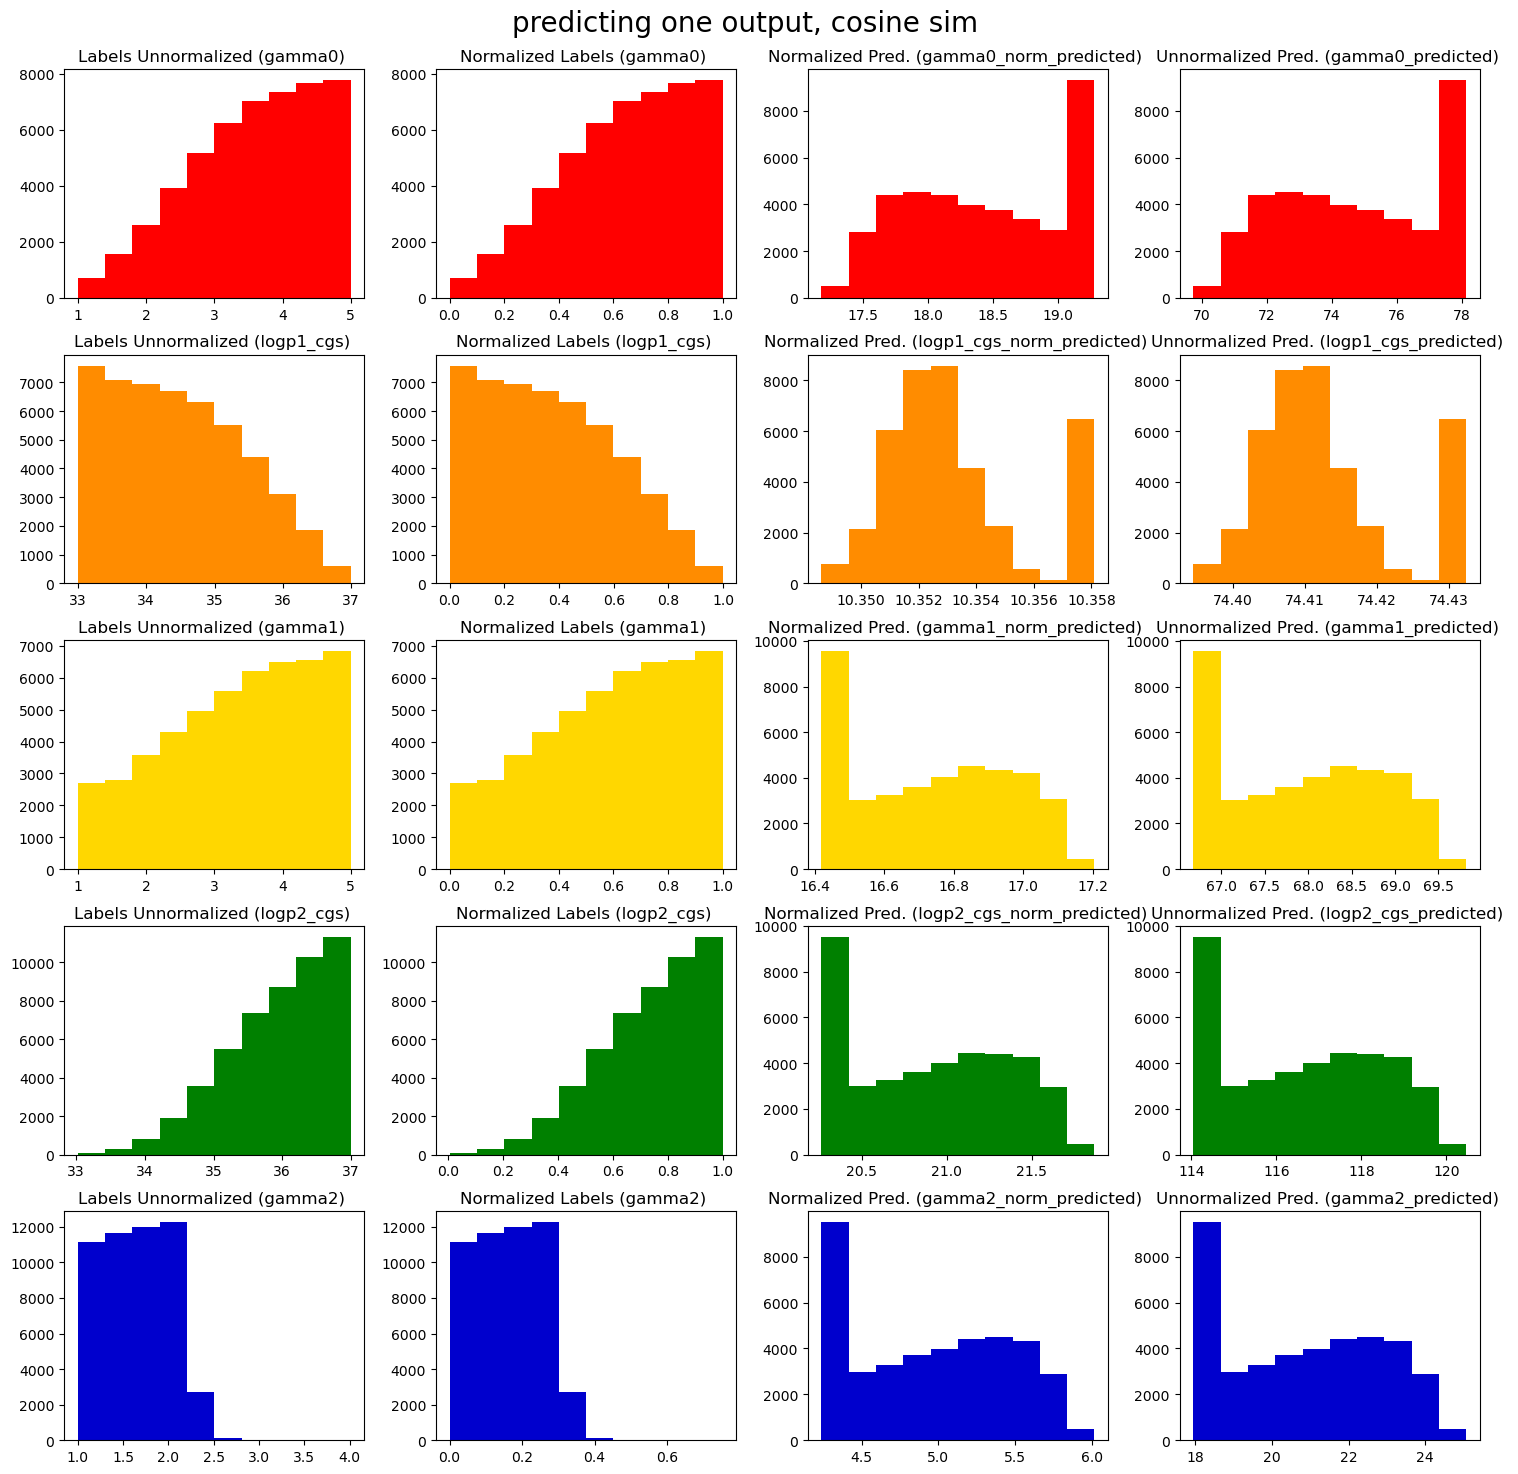

In [83]:
import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color)#, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color) #range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color)#, range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color)#, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('predicting one output, cosine sim', fontsize=20)
plt.show()